Dane jakości powietrza w Krakowie od stycznia 2021 do maja 2024. Stacja pomiarowa na al. Krasińskiego.

Każda godzinowa próbka zawiera pomiary 7 wielkości w powietrzu: benzenu, tlenku węgla, wszystkich tlenków azotu, tlenku azotu, dwutlenku azotu, pyłu zawieszonego PM10 oraz pyłu zawieszonego PM2,5.

Dane zaczerpnięte z https://powietrze.gios.gov.pl/pjp/current/station_details/archive/400.

### Model 3. Przewidywanie tylko jednego kroku naprzód ("one step at a time")

Niech pojedyncza próbka $x_i$ zarejestrowana w czasie $t_i$ będzie $k$-wymiarowym wektorem postaci $x_i = \left[ x_i^{(1)} \ldots x_i^{(k)} \right]^T$.

Załóżmy, że na podstawie $n$ uporządkowanych w czasie próbek $x_1,\ldots,x_n$ chcemy dokonać $m$ predykcji $x^*_{n+1},\ldots,x^*_{n+m}$ na czas $t_{n+1},\ldots,t_{n+m}$, gdzie każda predykcja również jest $k$-wymiarowym wektorem.

W ninejszym modelu model wykonuje sekwencję predykcji: ciąg próbek $\left( x_1,\ldots,x_n \right)$ jest przekształcany na predykcję $x^*_{n+1}$. Predykcja ta jest traktowana jako dane wejściowe dla ciągu $\left(x_2,\ldots,x_n,x^*_{n+1}\right)$, z którego uzyskiwana jest predykcja $x^*_{n+2}$ itd.

Mając wszystkie predykcje $x^*_{n+1},\ldots,x^*_{n+m}$, łączymy je w jeden wektor $\begin{bmatrix}
x^*_{n+1} \\
\vdots \\
x^*_{n+m}
\end{bmatrix}$ o wymiarze $km$. 

Podczas procesu uczenia model wykonuje jedynie predykcję $x^*_{n+1}$ na podstawie ciągu $\left( x_1,\ldots,x_n \right)$, a przy obliczaniu błędu z danymi faktycznymi predykcja ta jest porównywana z próbką $y_{n+1}$.

Model ten jest w działaniu identyczny jak model 2. Różnica jedynie występuje w procesie uczenia.

In [211]:
import pandas as pd
import numpy as np
import glob
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Mamy około 40 plików .csv od stycznia 2021-maj 2024 na każdy miesiąc.
# Plan jest taki, żeby wszystkie te .csv-ki połączyć w jedną - bo dużo łatwiej zaimportować!
 
# Folder z .csv-kami z każdego miesiąca.
data_dir = 'data'
# Zebranie wszystkich nazw owych .csv-ek w jedną listę.
csv_files = glob.glob(f'{data_dir}/gios**.csv')
# Kolumny w danych od GIOS są tragicznie ponazywane, więc tutaj nazwy którymi my będziemy się posługiwać.
column_names = ['Date', 'Benzene', 'CO', 'NOs', 'NO', 'N02', 'PM10', 'PM25']
# Lista na kolejne wiersze plików (z pominięciem pierwszych wierszy w każdym, który zawiera nazwy kolumn).
lines = []

# Pierwszy wiersz w połączonym .csv, który zawiera nazwy kolumn oddzielone przecinkami.
str_buffer = '' 
for column_name in column_names:
    str_buffer += column_name + ','
str_buffer += '\n'
lines.append(str_buffer)

# Wczytujemy linie z kolejnych plików.
for _, csv in enumerate(csv_files):
    with open(csv, mode = 'r') as file:
        # Pomijamy pierwszy wiersz
        file.readline()
        lines += file.readlines()

# Zapisujemy całość do nowego pliku.
merged_filename = 'data/data_merged.csv'
with open(merged_filename, mode = 'w') as file:
    file.writelines(lines)

# Tworzymy DataFrame. 
df = pd.read_csv(merged_filename, on_bad_lines = 'skip')
df.drop([df.columns[-1]], axis = 'columns', inplace = True)
for column in df.columns[1:]:
    df[column] = pd.to_numeric(df[column], errors = 'coerce')


# "Drobne" braki zastępujemy poprzednimi w czasie wartościami.
df.ffill(inplace = True)
df['Date'] = pd.to_datetime(df['Date'], format = 'ISO8601')
df.set_index('Date', inplace = True)
df.sort_index(inplace = True)

# Ujemne wielkości ustawiamy na zero.
for col in df.columns:
    df[col] = df[col].clip(lower = 0)

# Niektóre z danych są skrajnie zawyżone - prawdopodobnie błąd przy pomiarze.
df['Benzene'] = df['Benzene'].clip(upper = 10)
df['CO'] = df['CO'].clip(upper = 5)

# Póki co dzielimy całość na trzy przedziały w proporcji 80-10-10, które w dalszej części będziemy przetwarzać.
df_train, df_test = train_test_split(df, train_size = 0.8, shuffle = False)
df_test, df_valid = train_test_split(df_test, test_size = 0.5, shuffle = False)

# Standaryzacja.
train_stats = df_train.describe().transpose()
for col in df_train.columns:
    mean = train_stats.loc[col, 'mean']
    std = train_stats.loc[col, 'std']
    df_train[col] = (df_train[col] - mean) / std
    df_test[col] = (df_test[col] - mean) / std
    df_valid[col] = (df_valid[col] - mean) / std


In [212]:
# Długość pojedynczej "próbki" treningowej. Tyle kolejnych obserwacji przekażemy w jednej próbce do naszej sieci podczas uczenia.
training_window_length = 24 * 7
# Długość danych przekazywanych podczas testów i walidacji.
test_window_length = 24 * 3
valid_window_length = 24 * 3
# Z jakim przesunięciem będziemy tworzyć próbki. Np. mając dane [1, 2, 3, 4, 5, 6, 7, 8], window_length = 3 i stride = 1
# stworzymy próbki [1, 2, 3], [2, 3, 4], [3, 4, 5] itd, a dla stride = 2 stworzymy [1, 2, 3], [3, 4, 5], [5, 6, 7] itd.
training_window_stride = 1
test_window_stride = 1
valid_window_stride = 1
# Ile kroków czasowych w przysżłość będziemy przewidywać na podstawie przekazanego okna. 
training_prediction_length = 1
test_prediction_length = 1
valid_prediction_length = 1
# Liczba parametrów w pojedynczej obserwacji.
input_size = len(df_train.columns)
# Liczba parametrów w przewidywaniu. Z reguły taka sama i nie inaczej jest u nas. :)
output_size = input_size

X_train, y_train = [], []
X_test, y_test = [], []
X_valid, y_valid = [], []

for i in range(0, len(df_train) - training_window_length - training_prediction_length, training_window_stride):
    x = df_train.iloc[i : i + training_window_length].to_numpy()
    y = df_train.iloc[i + training_window_length: i + training_window_length + training_prediction_length].to_numpy().reshape(training_prediction_length * input_size)
    X_train.append(x)
    y_train.append(y)

for i in range(0, len(df_test) - test_window_length - test_prediction_length, test_window_stride):
    x = df_test.iloc[i : i + test_window_length].to_numpy()
    y = df_test.iloc[i + test_window_length: i + test_window_length + test_prediction_length].to_numpy().reshape(test_prediction_length * input_size)
    X_test.append(x)
    y_test.append(y)

for i in range(0, len(df_valid) - valid_window_length - valid_prediction_length, valid_window_stride):
    x = df_valid.iloc[i : i + valid_window_length].to_numpy()
    y = df_valid.iloc[i + valid_window_length: i + valid_window_length + valid_prediction_length].to_numpy().reshape(valid_prediction_length * input_size)
    X_valid.append(x)
    y_valid.append(y)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()
X_valid, y_valid = torch.tensor(X_valid).float(), torch.tensor(y_valid).float()

batch_size = 32
train_ds, test_ds, valid_ds = TensorDataset(X_train, y_train), TensorDataset(X_test, y_test), TensorDataset(X_valid, y_valid)
train_dl, test_dl, valid_dl = DataLoader(train_ds, shuffle = True, batch_size = batch_size), DataLoader(test_ds, shuffle = True, batch_size = batch_size), DataLoader(valid_ds, shuffle = True, batch_size = batch_size)

In [213]:
class SingleOutputModel(nn.Module):
    """Klasa z modułem do przewidywania jakości powietrza.
    Zawiera sieć LSTM z dołączoną siecią "klasyczną" na wyściu. 
    
    Do wejścia LSTM przekazywana jest sekwencja próbek rozmiaru `input_size`.
    Na wyjściu z niej dostajemy wektor rozmiaru `hidden_state_size * num_stacks * (1 + (include_cell_state == True))`,
    który następnie jest przekazywany do sieci gęstej. 
    
    Attributes:
        input_size : Wymiar pojedynczej próbki w czasie.
        hidden_state_size : Rozmiar stanu ukrytego.
        num_stacks : Liczba warstw w sieci LSTM.
        include_cell_state : Czy do sieci gęstej przekazujemy tylko hidden state sieci LSTM, czy zarówno hidden jak i cell state.
        dropout : Parametr `dropout` w sieci LSTM.
        lstm : Sieć LSTM.
        dense : Sieć gęsta do której przekazywany jest odpowiednie wyjście z LSTM.

    """
    def __init__(self, input_size, hidden_state_size, num_stacks, dropout, dense_layers, include_cell_state = False):
        """Inicjuje model.
        
        Args:
            input_size : Wymiar pojedynczej próbki w czasie.
            hidden_state_size : Rozmiar stanu ukrytego.
            num_stacks : Liczba warstw w sieci LSTM.
            dense_layers : Lista warstw "klasycznej" sieci.
            dropout : Parametr `dropout` w sieci LSTM.
            include_cell_state : Czy do sieci gęstej przekazujemy tylko hidden state sieci LSTM, czy zarówno hidden jak i cell state.
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_state_size = hidden_state_size
        self.num_stacks = num_stacks
        self.dropout = dropout
        self.include_cell_state = include_cell_state
        
        self.lstm = nn.LSTM(input_size, hidden_state_size, num_stacks, batch_first = True, dropout = dropout, bidirectional = False)
        self.dense = nn.ModuleList(dense_layers)

    def forward(self, X):
        """Wykonanie predykcji na danych.
        
        Args:
            X: Tensor z danymi wejściowmi.
        
        Returns:
            Tensor z predykcją.
        """
        _, (hn, cn) = self.lstm(X)
        
        out = hn
        if self.include_cell_state:
            out = torch.cat((out, cn), axis = 2)
        out = torch.transpose(out, dim0 = 0, dim1 = 1)
        out = torch.flatten(out, start_dim = 1, end_dim = 2)
        for layer in self.dense:
            out = layer(out)
        return out

    def long_predict(self, X, seek_steps = 1, constant_window = True):
        """Ponieważ model domyślnie przewiduje tylko jeden krok w przyszłość, niniejsza metoda
        służy do "przyrostowego" przewidywania dłuższych przedziałów czasowych, bazując
        kolejne predykcje na wcześniejszych predykcjach.

        Oznaczmy X jako [d_1,...,d_n]. Na początku dokonujemy predykcji na całości X i otrzymujemy predykcję p_{n+1}. 
        Jeżeli `constant_window = False`, to dokonujemy predykcji p_{n+2} na podstawie danych [d_1,...,d_n, p_{n+1}].
        W przeciwnym razie, obliczamy ją na podstawie [d_2,...,d_n,p_{n+1}].
        Kolejno, predykcja p_{n + 3} obliczana jest na podstawie [d_1,...,d_n, p_{n+1}, p_{n+2}] lub [d_3,...,d_n, p_{n+1}, p_{n+2}]
        w zależności od wartości `constant_window`. Cały proces powtarzany jest `seek_steps` razy. Zwraca on wszystkie [p_{n+1},...,p_{n+seek_steps}].

        Args:
            X : Tensor sekwencyjnych danych wejściowych.
            seek_steps : Ile kroków w przyszłość będziemy przewidywać.
            constant_window : Jeżeli `True`, to w kolejnych predykcjach będziemy odrzucać najstarsze dane z X.

        Returns:
            Tensor predykcji na kolejne `seek_steps` kroków.

        Raises:
            ValueError : Gdy `seek_steps` jest mniejsze od 1.
        
        """
        if seek_steps < 1:
            raise ValueError('Nie można przewidzieć mniej niż jednej obserwacji w przyszłość.')
        self.eval()
        window = X
        predictions = X
        with torch.no_grad():
            for _ in range(seek_steps):
                prediction = self(window)
                prediction = torch.unsqueeze(prediction, axis = 1)
                predictions = torch.cat((predictions, prediction), axis = 1)
                window = torch.cat((window, prediction), axis = 1)
                if constant_window:
                    window = window[:, 1:, :]
        return predictions[:, -seek_steps:, :]

    def fit(self, 
            data_train, 
            data_test, 
            loss_function_t,
            optimizer_t,
            learning_rate = 0.01,
            learning_gamma = 1,
            num_epochs = 10,
            verbose = False,
            device = torch.device('cpu')):
        """Metoda uczenia modelu.

        Args:
            data_train : Dataloader z danymi treningowymi.
            data_test : Dataloader z danymi testowymi.
            loss_function_t : Typ funkcji straty (np. MSELoss).
            optimizer_t : Typ optymalizatora (np. Adam).
            learning_rate : Prędkość uczenia.
            learning_gamma : Dropoff prędkości uczenia z kroku na krok.
            num_epochs : Liczba epok.
            verbose : Czy wypisywać progress uczenia.
            device : Jednostka, na której wykonywane będzie uczenie.

        Returns:
            Średnie błędy na zbiorach treningowym oraz testowym w kolejnych epokach.
        """
        loss_function = loss_function_t()
        optimizer = optimizer_t(self.parameters(), lr = learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optimizer, step_size = 1, gamma = learning_gamma)

        losses_train, losses_test = [], []
        for epoch in range(num_epochs):
            self.train()
            for X, y in data_train:
                X = X.to(device)
                y = y.to(device)
                pred = self(X)
                loss = loss_function(pred, y)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
        
            scheduler.step()
            self.eval()
            with torch.no_grad():
                total_loss = 0
                for X, y in data_train:
                    X = X.to(device)
                    y = y.to(device)
                    pred = self(X)
                    loss = loss_function(pred, y)
                    total_loss += loss.item()
                
                losses_train.append(total_loss / len(data_train))

                total_loss = 0
                for X, y in data_test:
                    X = X.to(device)
                    y = y.to(device)
                    pred = self(X)
                    loss = loss_function(pred, y)

                    total_loss += loss.item()

                losses_test.append(total_loss / len(data_test))

                if verbose:
                    print(f'Epoch: {epoch + 1:4d} / {num_epochs}, Losses (train / test): {losses_train[-1]:4.4f} / {losses_test[-1]:4.4f}')



        return losses_train, losses_test

In [214]:
model = SingleOutputModel(input_size = input_size, 
                          hidden_state_size = 10, 
                          num_stacks = 3, 
                          dropout = 0.5, 
                          include_cell_state = False, 
                          dense_layers = [
   nn.Linear(10 * 3 * 1, 50),
   nn.ReLU(),
   nn.Dropout(p = 0.5),
   nn.Linear(50, output_size),
])

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
model = model.to(device)

num_epochs = 2
learning_rate = 0.001
learning_gamma = 0.9

results = model.fit(
   train_dl,
   test_dl,
   nn.MSELoss,
   torch.optim.NAdam,
   device = device,
   num_epochs = num_epochs,
   verbose = True,
   learning_rate = learning_rate,
   learning_gamma = learning_gamma
)

Epoch:    1 / 2, Losses (train / test): 0.2546 / 0.2295
Epoch:    2 / 2, Losses (train / test): 0.2127 / 0.1849


In [215]:
model_cpu = model.cpu()
model_cpu.eval()

# Jak duże będzie okno danych przekazanych do predykcji.
prediction_input_length = valid_window_length
prediction_output_length = 24

# Parametr constant_window w long_predict modelu.
constant_window = True

# Przy uczeniu porównywaliśmy wyniki z samplami dla tylko jednej godziny. Do porównania skuteczności z innymi modelami zrobimy DataLoader z wynikami 24-godzinnymi.
X_valid_long = []
y_valid_long = []
for i in range(0, len(df_valid) - prediction_input_length - prediction_output_length):
    x = df_valid.iloc[i : i + prediction_input_length].to_numpy()
    y = df_valid.iloc[i + prediction_input_length: i + prediction_input_length + prediction_output_length].to_numpy()
    X_valid_long.append(x)
    y_valid_long.append(y)

X_valid_long, y_valid_long = np.array(X_valid_long), np.array(y_valid_long)
X_valid_long, y_valid_long = torch.tensor(X_valid_long).float(), torch.tensor(y_valid_long).float()

valid_long_ds = TensorDataset(X_valid_long, y_valid_long)
valid_long_dl = DataLoader(valid_long_ds, shuffle = True, batch_size = batch_size)


total_loss = 0
with torch.no_grad():
    loss_fn = nn.MSELoss()
    for X, y in valid_long_dl:
        pred = model_cpu.long_predict(X, seek_steps = prediction_output_length, constant_window = constant_window)
        loss = loss_fn(pred, y)
        total_loss += loss.item()
    total_loss = total_loss / len(valid_long_dl)
            
    print(f'Average valid loss (MSE): {total_loss}.')

Average valid loss (MSE): 0.6241841058178645.


In [216]:
from datetime import datetime
import os

# Zapisanie logów.
logs_dir = 'logs/model_one'
if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)
now = datetime.now()
filename = f'{total_loss:.3f}_{now.strftime('%d_%m_%Y_%H_%M_%S.txt')}'
filepath = logs_dir + '/' + filename
with open(filepath, mode = 'w+') as file:
    file.write(now.strftime('%d/%m/%Y, %H:%M:%S\n'))
    file.write(str(model) + '\n')
    file.write(f'Hidden state only: {not model.include_cell_state}\n')
    file.write(f'Batch size: {batch_size}\n')
    file.write(f'Training size: {training_window_length}\n')
    file.write(f'Epochs: {num_epochs}\n')
    file.write(f'Learning rate: {learning_rate}\n')
    file.write(f'Learning gamma: {learning_gamma}\n')
    file.write(f'Final training loss (MSE): {results[0][-1]}\n')
    file.write(f'Final test loss (MSE): {results[1][-1]}\n')
    file.write(f'Final valid loss (MSE): {total_loss}\n')

# Zapisanie modelu do pliku.
models_dir = 'models/one'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
now = datetime.now()
filename = f'{total_loss:.3f}_{now.strftime('%d_%m_%Y_%H_%M_%S')}.pt'
filepath = models_dir + '/' + filename
torch.save(model_cpu, filepath)

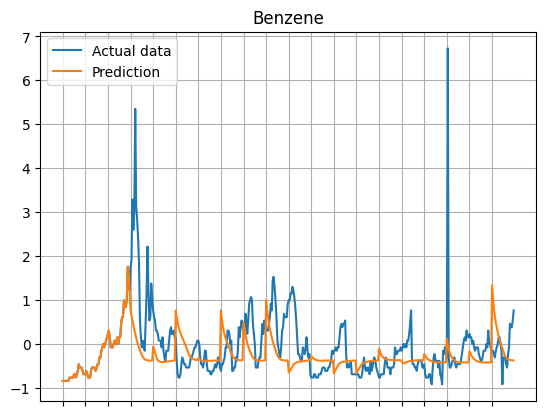

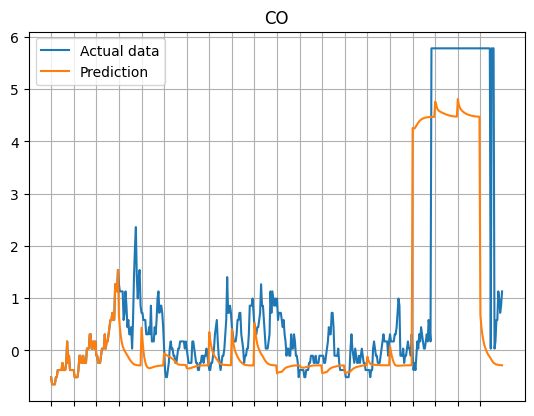

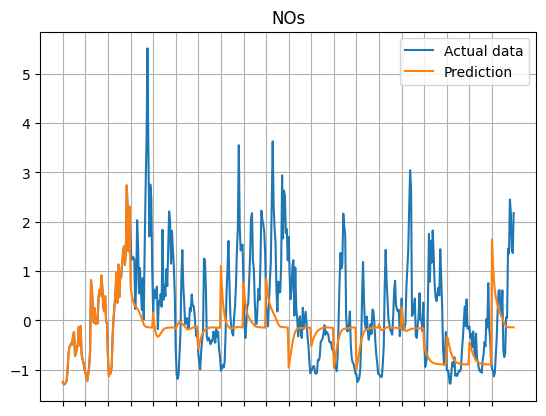

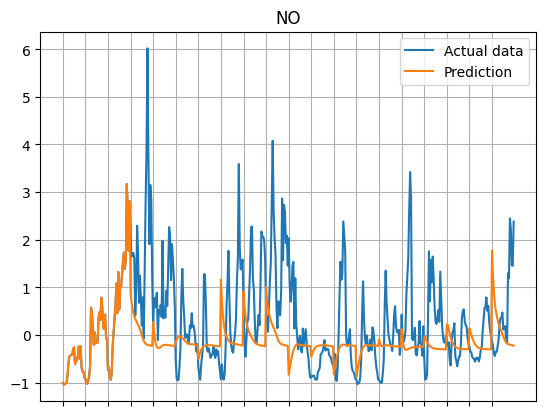

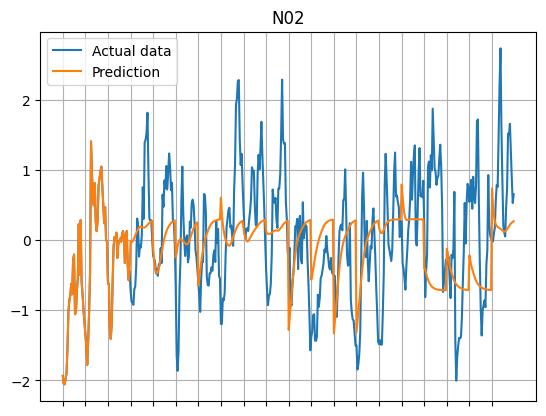

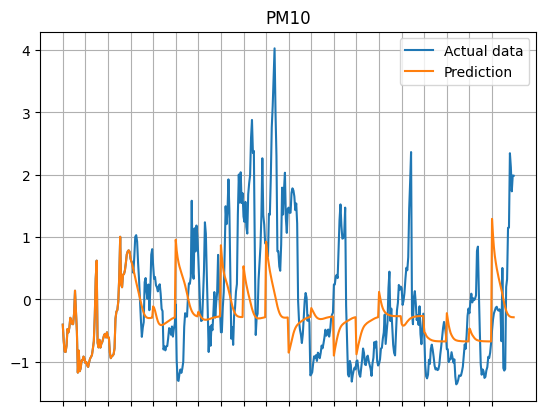

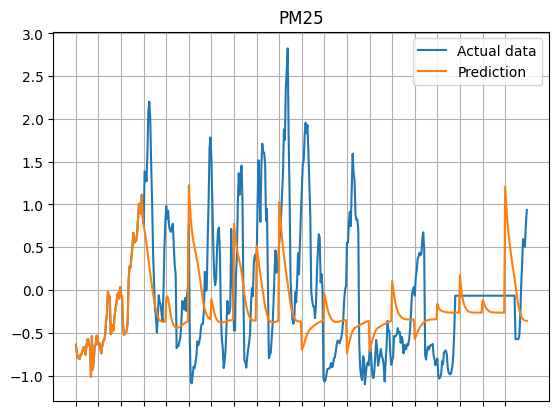

In [217]:
# Zilustrowanie działania modelu na kawałku danych walidacyjnych.
continuous_data = df_valid.iloc[:20 * 24 :].to_numpy()

preds, obs = [], continuous_data
for observation in continuous_data[:prediction_input_length]:
    preds.append(observation)

# Przykładowo: dla danych [0, 1, 2,...,], prediction_input_length = 4, prediction_seek_steps = 2 będziemy mieć następujące predykcje:
# [0, 1, 2, 3] -> [p4, p5] - oczywiście w tym momencie jeszcze nie znamy dokładnego 4 i 5, bo ten czas z tego punktu widzenia to wciąż przyszłość. :)
# [2, 3, 4, 5] -> [p6, p7] - w tym momencie już 4 i 5 zaszło i mamy dokładne wartości (możemy sobie np. porównać naszą predykcję p4 i p5 z dokładnym 4 i 5). Przewidujemy p6 i p7.
# [4, 5, 6, 7] -> [p8, p9] - itd...
total_num_of_predictions = (len(continuous_data) - prediction_input_length) // prediction_output_length
for i in range(total_num_of_predictions):
    slice = continuous_data[i * prediction_output_length : (i + 1) * prediction_output_length + prediction_input_length]
    slice = torch.tensor(slice)
    slice = torch.unsqueeze(slice, dim = 0).float()
    prediction = model_cpu.long_predict(slice, seek_steps = prediction_output_length, constant_window = constant_window)
    prediction = torch.squeeze(prediction, dim = 0).numpy()
    for p in prediction:
        preds.append(p)

preds = np.array(preds).T
obs = np.array(obs).T

for pred, ob, col in zip(preds, obs, df_valid.columns):
    plt.plot(ob, label = 'Actual data')
    plt.plot(pred, label = 'Prediction')
    plt.title(col)
    plt.xticks(np.arange(0, len(continuous_data), 24))
    plt.tick_params(labelbottom = False)
    plt.grid()
    plt.legend()
    plt.show()

In [218]:
# Wyeksportowanie całej predykcji do pliku.
continuous_data = df_valid.iloc[:].to_numpy()
timestamps = df_valid.index.to_numpy()

preds, obs = [], continuous_data
for observation in continuous_data[:prediction_input_length]:
    preds.append(observation)

total_num_of_predictions = (len(continuous_data) - prediction_input_length) // prediction_output_length
for i in range(total_num_of_predictions):
    slice = continuous_data[i * prediction_output_length : (i + 1) * prediction_output_length + prediction_input_length]
    slice = torch.tensor(slice)
    slice = torch.unsqueeze(slice, dim = 0).float()
    prediction = model_cpu.long_predict(slice, seek_steps = prediction_output_length, constant_window = constant_window)
    prediction = torch.squeeze(prediction, dim = 0).numpy()
    for p in prediction:
        preds.append(p)

preds = np.array(preds)
obs = np.array(obs)

mean = train_stats.loc[:, 'mean'].to_numpy()
std = train_stats.loc[:, 'std'].to_numpy()

out_dir = './out'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

filepath = out_dir + '/' + 'one_valid'
with open(filepath, mode = 'w+') as file:
    for i, col_name in enumerate(column_names):
        file.write(col_name + (',' if i != len(column_names) - 1 else '\n'))
    for t, pred in zip(timestamps, preds):
        file.write(str(t) + ',')
        pred *= std
        pred += mean
        for i, value in enumerate(pred):
            file.write(str(value) + (',' if i != len(pred) - 1 else '\n'))

filepath = out_dir + '/' + 'true_valid'
with open(filepath, mode = 'w+') as file:
    for i, col_name in enumerate(column_names):
        file.write(col_name + (',' if i != len(column_names) - 1 else '\n'))
    for t, ob in zip(timestamps, obs):
        file.write(str(t) + ',')
        ob *= std
        ob += mean
        for i, value in enumerate(ob):
            file.write(str(value) + (',' if i != len(ob) - 1 else '\n'))